In [15]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
import io
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import requests
# import babel.numbers
# import decimal
#import locale
#locale.setlocale( locale.LC_ALL, '' )


from User_input import st_file_selector, Prior_probability_binary, make_value_array
from Naive_Bayes import make_train_test, optimal_bin
from Bayesian_Modeling import likelihood_KDE, Scaledlikelihood_KDE, Posterior_by_hand, Posterior_Marginal_plot, marginal, Posterior_via_NaiveBayes
from VOI import Vperfect, f_MI, f_VIMPERFECT, f_VPRIOR

## Prior probability of Success

In [ ]:
Pr_prior_POS = 0.4 # Default value

## Vprior for 3km drilling

**INSERT Text explains what this is**

In [ ]:
pos_drill_outcome = 150000000
neg_drill_outcome = -4.11e6
value_array, value_array_df = make_value_array(count_ij, profit_drill_pos= pos_drill_outcome, cost_drill_neg = neg_drill_outcome)

vprior_unif_out = f_VPRIOR([1-Pr_prior_POS,Pr_prior_POS], value_array) #, value_drill_DRYHOLE[-1]       
                       

# Left Panel of App: Loading Files and Features

In [16]:
url = 'https://github.com/wtrainor/INGENIOUS_streamlit/raw/main/File Template/POS_COMBINED_NEW_JULYRESID_INGENIOUS_updated.csv'
pos_file = requests.get(url).content


url = 'https://github.com/wtrainor/INGENIOUS_streamlit/raw/main/File Template/NEG_COMBINED_NEW_JULYRESID_INGENIOUS_updated.csv'
neg_file = requests.get(url).content
# Positive file if user chooses to upload should have PosSite_Distance (distance to positive sites)
# Negative file if user chooses to upload should have NegSite_Distance (distance to negative sites)
# Plots (functions) are only for streamlit... use normal methods to plot otherwise.

# Plotting Likelihood and Assigning Inputs

In [17]:
df = pd.read_csv(io.StringIO(pos_file.decode('utf-8')))

dfN = pd.read_csv(io.StringIO(neg_file.decode('utf-8')))
attribute  = df.columns[7] # Randomly choosing one. If the use wishes to choose one manually, change the code here

df_sc = df[df[attribute]>-9999]
df_scN = dfN[dfN[attribute]>-9999]
dist_met = np.max(df_sc['PosSite_Distance'].quantile(0.1)) # Can change here as well
dist_met = 800

In [18]:
dfpair00 = df_sc[(df_sc['PosSite_Distance'] <=round(dist_met,-1))] 
neg_site_col_name = 'NegSite_Distance'        
dfpair = dfpair00[dfpair00[attribute]>-9999] 
# # # OJO : may want to keep this off until have it for NEG 
dfpairN = df_scN[(df_scN[neg_site_col_name] <=round(dist_met,-1))] 
if np.shape(dfpairN)[0]==0:
    dfpairN = df_scN[(df_scN[neg_site_col_name ] <= np.percentile(df_scN[neg_site_col_name ],10))] 


2024-10-31 09:32:25.958 
  command:

    streamlit run c:\Users\kmenon\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


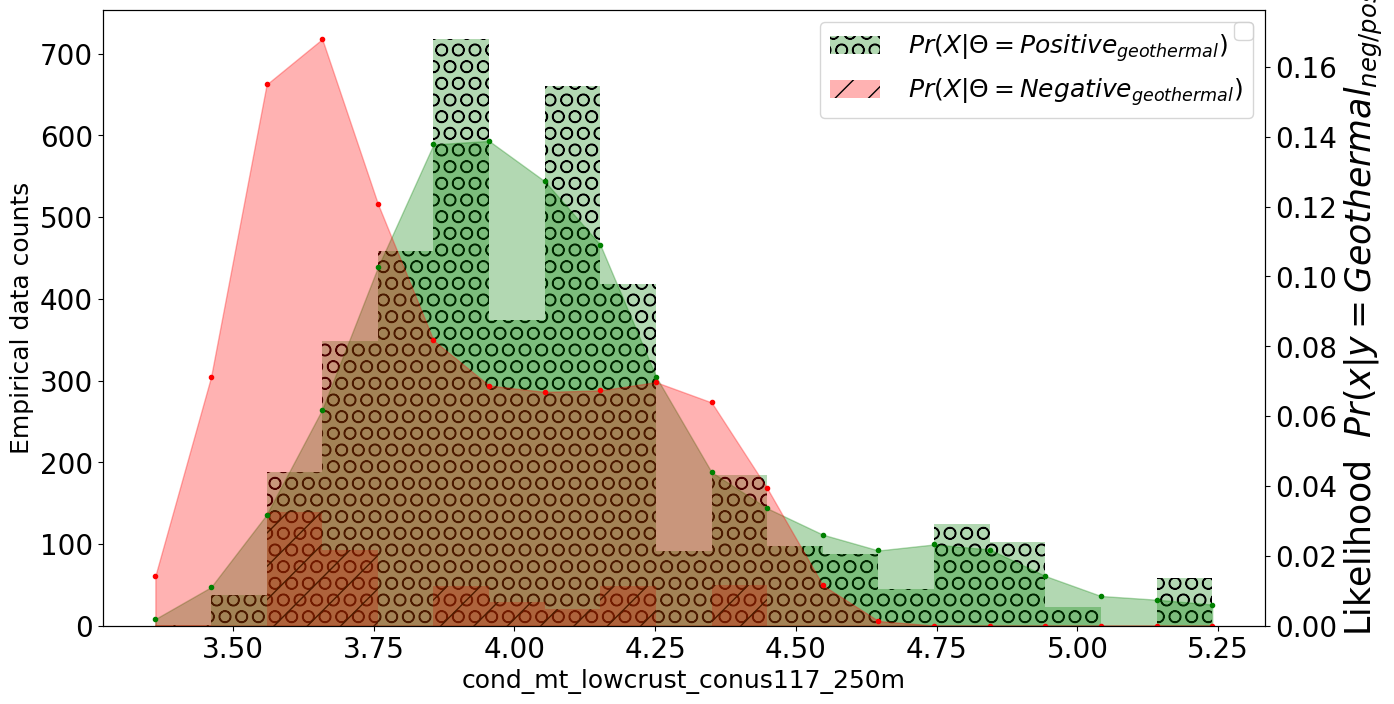

In [19]:
%matplotlib inline
X_train, X_test, y_train, y_test = make_train_test(dfpair,attribute,dfpairN)
 
best_params, accuracy = optimal_bin(X_train, y_train)

# Likelihood via KDE estimate
predictedLikelihood_pos, predictedLikelihood_neg, x_sampled, count_ij= likelihood_KDE(X_train,X_test, y_train, y_test,attribute, best_params)
# Likelihood plot is plotted below

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\kmenon\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kmenon\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


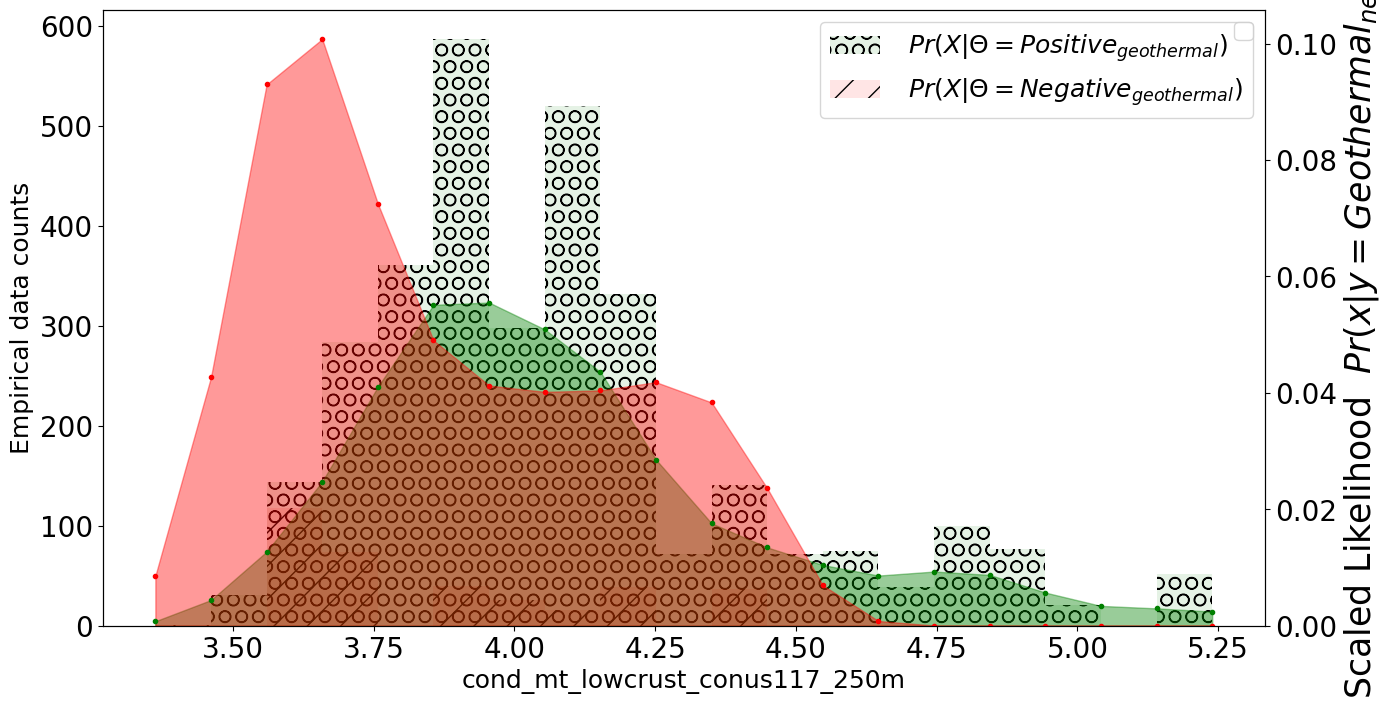

In [20]:
# Scaled Likelihood plots
%matplotlib inline

Scaledlikelihood_KDE(Pr_prior_POS,predictedLikelihood_neg, predictedLikelihood_pos,X_train,X_test, y_train, y_test,attribute,x_sampled, best_params)          
# POSTERIOR via_Naive_Bayes: Draw back here the marginal not using scaled likelihood..
post_input, post_uniform = Posterior_via_NaiveBayes(Pr_prior_POS,X_train, X_test, y_train, y_test, x_sampled, attribute)
             
# # DO NOT USEmymodule.marginal( because it's passing unscaled likelihood!!!)
# # Pr_Marg = mymodule.marginal(Pr_prior_POS, predictedLikelihood_pos, predictedLikelihood_neg, x_sampled)
# WAS inputting: post_input, post_uniform, Pr_Marg, x_cur, x_sampled)

2024-10-31 09:32:28.181 Session state does not function when running a script without `streamlit run`


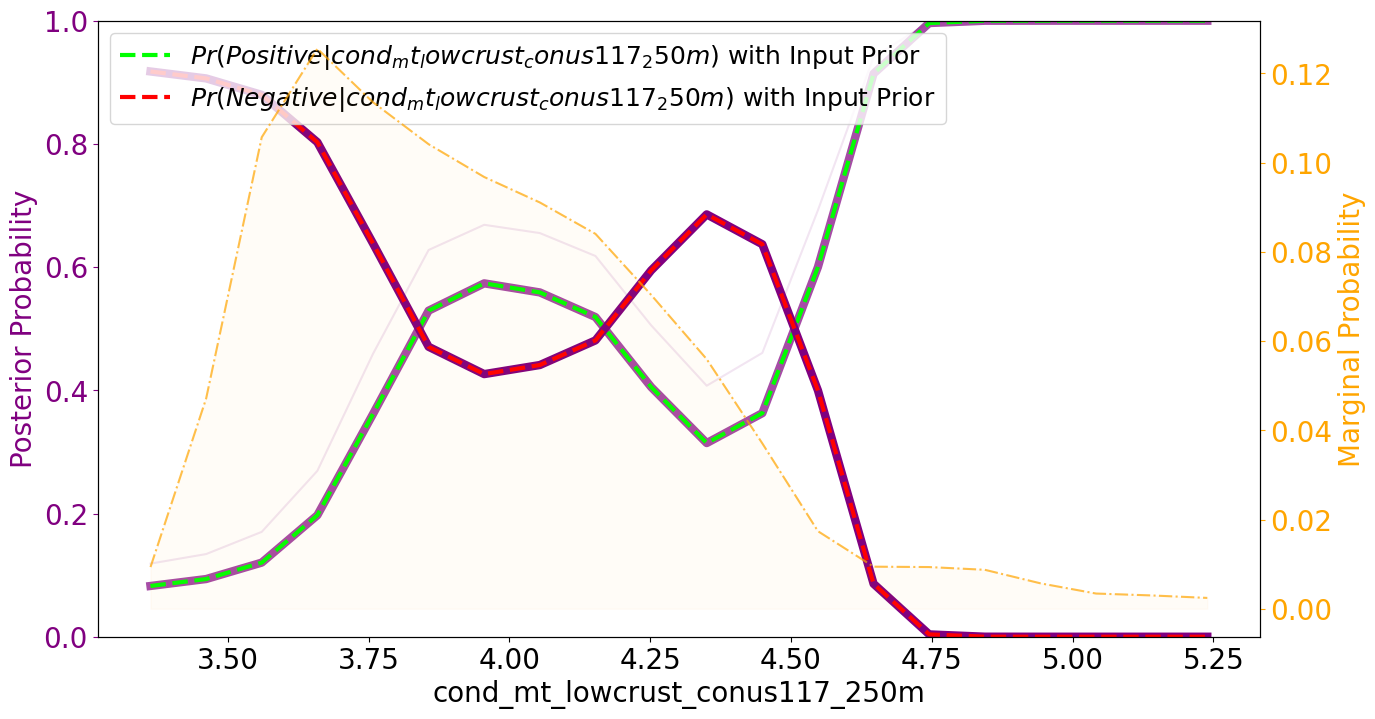

In [21]:
%matplotlib inline
Pr_InputMarg, Pr_UnifMarg, Prm_d_Input, Prm_d_Uniform = Posterior_by_hand(Pr_prior_POS,predictedLikelihood_pos, predictedLikelihood_neg, x_sampled)
Posterior_Marginal_plot(Prm_d_Input, Prm_d_Uniform, Pr_InputMarg, attribute, x_sampled) 

# Value of Information Metrics Calculation

In [22]:
pos_drill_outcome = 1e7
neg_drill_outcome = -1e7
value_array, value_array_df = make_value_array(count_ij, profit_drill_pos= pos_drill_outcome, cost_drill_neg = neg_drill_outcome)

vprior_unif_out = f_VPRIOR([1-Pr_prior_POS,Pr_prior_POS], value_array) #, value_drill_DRYHOLE[-1]       
                       


VPI = Vperfect(Pr_prior_POS, value_array)
        
        
        
VII_input = f_VIMPERFECT(Prm_d_Input, value_array, Pr_InputMarg)
VII_unifPrior = f_VIMPERFECT(Prm_d_Uniform, value_array, Pr_UnifMarg)

In [23]:
print("Prior Value (Vprior) ($): ",vprior_unif_out)
print("Imperfect Value (Vimp) ($): ", VII_input)
print("Value of Imperfect Information ($): ",VII_input-vprior_unif_out)
print("Value of Perfect Information ($): ", VPI-vprior_unif_out)

Prior Value (Vprior) ($):  0.0
Imperfect Value (Vimp) ($):  780703.3120456443
Value of Imperfect Information ($):  780703.3120456443
Value of Perfect Information ($):  4000000.0


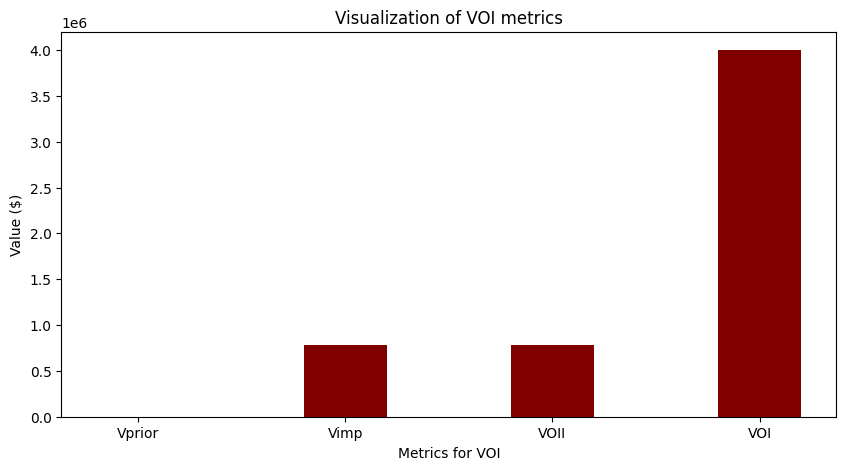

In [24]:
# Bar plot
%matplotlib inline
metric = list[['Vprior', 'Vimp', 'VOII', 'VOI']]
vals = list[vprior_unif_out,VII_input,(VII_input-vprior_unif_out), (VPI-vprior_unif_out)]

data = {'Vprior':vprior_unif_out, 'Vimp':VII_input, 'VOII':(VII_input-vprior_unif_out), 
        'VOI':(VPI-vprior_unif_out)}

metric = list(data.keys())
vals = list(data.values())
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(metric, vals, color ='maroon', 
        width = 0.4)

plt.xlabel("Metrics for VOI")
plt.ylabel("Value ($)")
plt.title("Visualization of VOI metrics")
plt.show()
